## Introduction:
In this note-book we will us the pre-processed validation data set and do feature transformation, dimensionality reduction and finally feature selection. On the way we will analyze feature selection process to ensure this data exhibit same charecteritics as training and test set. We will the use anomaly detection on the data set.   

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import mixture

In [2]:
val_file2=pd.read_csv('./Data/val1.csv')
val_df2=pd.DataFrame(val_file2)
val_df2.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,count,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,attack_type
0,0,udp,private,SF,105,146,0,0,0,1,...,1.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal,safe
1,0,udp,private,SF,105,146,0,0,0,1,...,1.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal,safe
2,0,udp,private,SF,105,146,0,0,0,1,...,1.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal,safe
3,0,udp,domain_u,SF,29,0,0,0,0,2,...,0.30,0.30,0.3,0.0,0.0,0.0,0.0,0.0,normal,safe
4,0,udp,private,SF,105,146,0,0,0,1,...,0.99,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal,safe


## Optimizing memory foot print

In [3]:
def dtype_transform(df, dt):
    int_types = ["int8", "int16", "int32", "int64"]
    float_types=["float16", "float32", "float64", "float128"]
    dmax=0
    dmin=0
    lmd_floatmax=lambda x: np.finfo(x).max
    lmd_floatmin=lambda x: np.finfo(x).min
    lmd_intmax=lambda x: np.iinfo(x).max
    lmd_intmin=lambda x: np.iinfo(x).min
    max_funct=None
    min_funct=None
    dt_types=[]
    if dt==float:
        dt_types=float_types
        max_funct=lmd_floatmax
        min_funct=lmd_floatmin
    elif dt==int:
        dt_types=int_types
        max_funct=lmd_intmax
        min_funct=lmd_intmin
    else:
        
        exit()
        
    selected_types=None    
    for i in df.columns:
        if df[i].dtypes==dt:
            
            dmax=df[i].max()
            dmin=df[i].min()
            for j in dt_types:
                if max_funct(j)>dmax and min_funct(j)<dmin:
                    
                    selected_types=j
                    
                    
                    break
                else:
                    
                    continue
            
            df[i]=df[i].astype(selected_types)

In [4]:
dtype_transform(val_df2, float)
dtype_transform(val_df2, int)

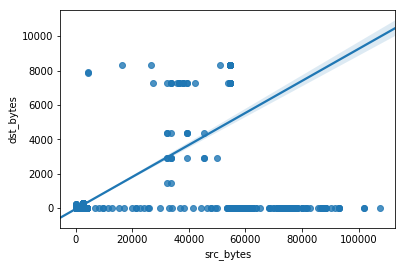

In [5]:
src_dos=val_df2[val_df2['attack_type']=='DOS']['src_bytes']
dst_dos=val_df2[val_df2['attack_type']=='DOS']['dst_bytes']
sns.regplot(src_dos, dst_dos)

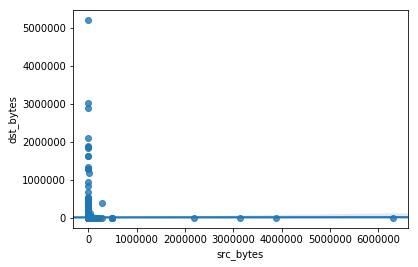

In [6]:
src_sfe=val_df2[val_df2['attack_type']=='safe']['src_bytes']
dst_sfe=val_df2[val_df2['attack_type']=='safe']['dst_bytes']
sns.regplot(src_sfe, dst_sfe)

# One Hot encoding


In [7]:
val_df2a=val_df2
#train_df2=pd.get_dummies(train_df1['service'])
prt_dummy=pd.get_dummies(val_df2['protocol_type'])
srv_dummy=pd.get_dummies(val_df2['service'])
flag_dummy=pd.get_dummies(val_df2['flag'])

In [8]:
def reduce_hotencode_sparcity(df, pct_allowed, indx=0):
    return [i for i in df.columns if 
            df[i].value_counts(normalize=True)[indx]*100<pct_allowed]

In [9]:
k=reduce_hotencode_sparcity(srv_dummy, pct_allowed=1, indx=1 )
l=reduce_hotencode_sparcity(flag_dummy, pct_allowed=1, indx=1 )

k=['IRC',
 'X11',
 'Z39_50',
 'auth',
 'bgp',
 'courier',
 'csnet_ns',
 'ctf',
 'daytime',
 'discard',
 'domain',
 'echo',
 'eco_i',
 'efs',
 'exec',
 'finger',
 'ftp',
 'ftp_data',
 'gopher',
 'hostnames',
 'http_443',
 'imap4',
 'iso_tsap',
 'klogin',
 'kshell',
 'ldap',
 'link',
 'login',
 'mtp',
 'name',
 'netbios_dgm',
 'netbios_ns',
 'netbios_ssn',
 'netstat',
 'nnsp',
 'nntp',
 'ntp_u',
 'pop_2',
 'pop_3',
 'printer',
 'red_i',
 'remote_job',
 'rje',
 'shell',
 'sql_net',
 'ssh',
 'sunrpc',
 'supdup',
 'systat',
 'telnet',
 'tftp_u',
 'tim_i',
 'time',
 'urh_i',
 'urp_i',
 'uucp',
 'uucp_path',
 'vmnet',
 'whois']
l=['OTH', 'RSTO', 'RSTR', 'S1', 'S2', 'S3', 'SH']

In [10]:
prt_dummy.drop(columns=['udp'], inplace=True)
srv_dummy.drop(columns=k, inplace=True)
flag_dummy.drop(columns=l, inplace=True)
val_df2a=pd.concat([val_df2a,prt_dummy], axis=1 )
val_df2a=pd.concat([val_df2a,srv_dummy], axis=1 )
val_df2a=pd.concat([val_df2a,flag_dummy], axis=1 )
val_df2a.shape

(290448, 40)

In [11]:
val_df2a.drop(columns=['protocol_type', 'service', 'flag'], inplace=True)

In [12]:
val_df2a.shape

(290448, 37)

In [13]:
Y=pd.DataFrame()

X2b=val_df2a.drop(columns=['attack_type','labels'])

In [14]:
X_bytes=pd.DataFrame()
X_bytes['abs_bytes_diff']=np.abs(val_df2a['src_bytes']-val_df2['dst_bytes'])
X_bytes['bytes_diff']=val_df2a['dst_bytes']-val_df2a['src_bytes']
X_bytes['attack_type']=val_df2['attack_type']
X_bytes['duration']=val_df2['duration']

In [15]:
cont_columns= ['duration', 'src_bytes', 'dst_bytes', 'count', 'wrong_fragment', 'urgent',
              'srv_count', 'serror_rate', 'srv_serror_rate','rerror_rate' ,'srv_rerror_rate',
              'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
              'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
              'dst_host_serror_rate','dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

In [16]:
X_cont=X2b[cont_columns]
X_disc=X2b.drop(columns=cont_columns)

In [17]:
X_disc.shape

(290448, 11)

In [18]:
X2b_cont1=X2b[['same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate','dst_host_count',
          'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
          'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate','serror_rate', 
          'srv_serror_rate','rerror_rate' , 'srv_rerror_rate','dst_host_serror_rate',
          'dst_host_srv_serror_rate','dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
           'count']]

## Dimensionality reduction using Principle Component Analysis

In [19]:
SS=StandardScaler()
X_cont_SS=SS.fit(X2b_cont1)
X_contSS=X_cont_SS.transform(X2b_cont1)

In [20]:
pca = PCA(n_components=10)
pca_fit = pca.fit(X_contSS)

In [21]:
var_exp = pca_fit.explained_variance_ratio_

cum_var_exp = np.cumsum(var_exp)


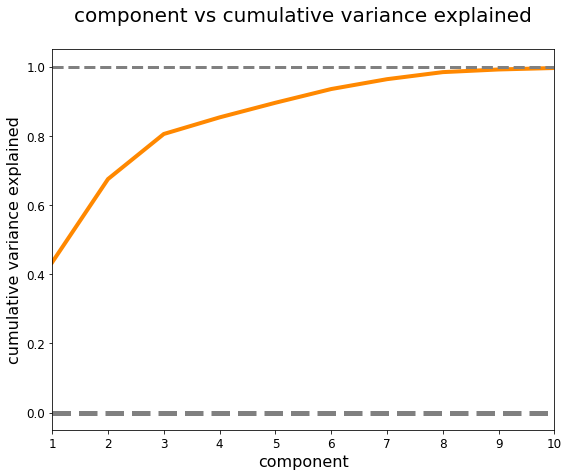

In [22]:
plt.figure(figsize=(9,7))

# HERE IS THE BASIC PLOT

# Plot the cumulative explained variance
component_number = [1,2,3,4,5,6,7,8,9,10]
plt.plot(component_number, cum_var_exp, lw=4, color='#ff8800')

# NOW MAKE IT LOOK PRETTY

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=3, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([1,10])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

Above plot shows that 8 out of 10 principle components captures the variation of the the selected 10 features similar to our training and test set

In [23]:
pca = PCA(n_components=8)
X_contSS_pca = pca.fit_transform(X_contSS)



In [24]:
SS1=StandardScaler()
X_discSS1=SS1.fit_transform(X_disc)

In [25]:
pca = PCA()
pca_fit1 = pca.fit(X_discSS1)

In [26]:
var_exp = pca_fit1.explained_variance_ratio_

cum_var_exp = np.cumsum(var_exp)


In [27]:
len(var_exp)

11

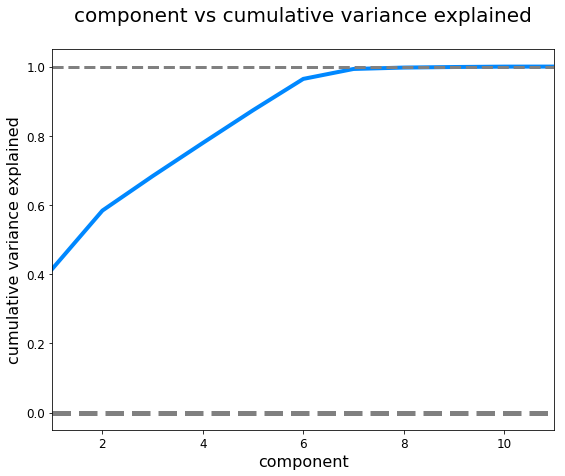

In [28]:
plt.figure(figsize=(9,7))

# HERE IS THE BASIC PLOT

# Plot the cumulative explained variance
component_number = [1,2,3,4,5,6,7,8,9,10, 11]
plt.plot(component_number, cum_var_exp, lw=4, color='#0088ff')

# NOW MAKE IT LOOK PRETTY

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=3, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([1,11])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

Above plot shows that 8 out of 11 principle components captures the variation of the the selected 11 features similar to our training and test set

In [29]:
pca = PCA(n_components=7)
X2b_disc_pca = pca.fit_transform(X_discSS1)

In [30]:
# X=np.concatenate((X2b_disc_pca,X_contSS), axis=1 )

In [31]:
X1=pd.DataFrame()
X1['abs_bytes_diff']=X_bytes['abs_bytes_diff']
X1['duartion']=val_df2['duration']

In [32]:
X_bytes.head()

,abs_bytes_diff,bytes_diff,attack_type,duration
0,41,41,safe,0
1,41,41,safe,0
2,41,41,safe,0
3,29,-29,safe,0
4,41,41,safe,0


In [33]:
from sklearn.preprocessing import MinMaxScaler
mms=MinMaxScaler(feature_range=(-9,26 ))
X1_mms=mms.fit_transform(X1)

In [34]:
X=np.concatenate((X2b_disc_pca,X_contSS_pca, X1_mms), axis=1 )

In [35]:
cols=[str(i) for i in range(17)]

In [36]:
X_yML=pd.DataFrame(X, columns=cols)

In [37]:
X_yML.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.911005,-0.225758,0.004825,0.226542,0.270511,-0.041155,2.483702,-0.815931,0.027775,0.866603,-1.085141,-1.309138,0.534919,0.269595,0.626139,-8.999772,-9.0
1,0.911005,-0.225758,0.004825,0.226542,0.270511,-0.041155,2.483702,-0.815931,0.027775,0.866603,-1.085141,-1.309138,0.534919,0.269595,0.626139,-8.999772,-9.0
2,0.911005,-0.225758,0.004825,0.226542,0.270511,-0.041155,2.483702,-0.815931,0.027775,0.866603,-1.085141,-1.309138,0.534919,0.269595,0.626139,-8.999772,-9.0
3,0.021539,1.305948,-0.258244,5.665931,7.812895,0.082003,-0.490362,6.799567,1.017962,2.743076,-0.930686,8.642377,17.227970,-3.319398,-3.074108,-8.999839,-9.0
4,0.911005,-0.225758,0.004825,0.226542,0.270511,-0.041155,2.483702,-0.803592,0.028177,0.865812,-1.082964,-1.307546,0.531747,0.269843,0.625265,-8.999772,-9.0


In [38]:
X_yML['attack_code']=X_bytes['attack_type'].map(lambda x: 1 if x=='DOS' else 0)

In [39]:
X_yML.isnull().sum()

0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11             0
12             0
13             0
14             0
15             0
16             0
attack_code    0
dtype: int64

## Storing data after PCA

In [40]:
X_yML.to_csv('./Data/X_yMLval.csv', index=False)

## Anomaly detection using Gaussian Mixture Model

In [44]:

clf = mixture.GaussianMixture(n_components=2, covariance_type='full', max_iter=1000, 
                              init_params='random', warm_start=True)
clf.fit(X)

GaussianMixture(covariance_type='full', init_params='random', max_iter=1000,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=True, weights_init=None)

In [49]:
gm=clf.predict(X)

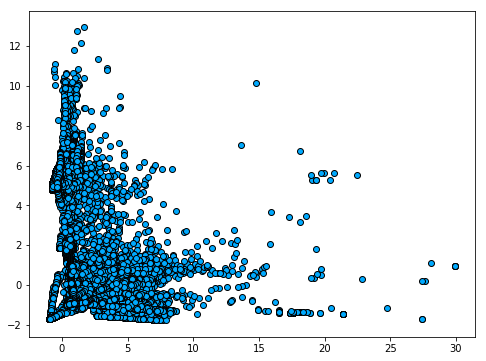

In [50]:
plt.figure(figsize=(8,6))
plt.scatter(X[gm==0, 9], X[gm==0, 7], color='#ff9900', marker='o',edgecolors='k')
plt.scatter(X[gm==1, 9], X[gm==1, 7], color='#00aaff', marker='o', edgecolors='k')
plt.show()

In [51]:
np.unique(gm)

array([0, 1])

In [52]:
X_bytes['label1']=gm

In [53]:
X_bytes[X_bytes['attack_type']=='DOS']['label1'].value_counts(normalize='True')

0    0.959
1    0.041
Name: label1, dtype: float64

In [54]:
X_bytes[X_bytes['attack_type']=='safe']['label1'].value_counts(normalize='True')

1    0.714967
0    0.285033
Name: label1, dtype: float64

## Summary
In this section we used feature engineering and dimensionaity reduction on validation data set. Then we performed anomaly detection using Gaaussian Mixture Model. Anomaly detection was able to detect 95.9% of DoS connections> 